In [1]:
# -------------------------------------------------------------------------
# Author:   Alberto Frizzera, info@albertofrizzera.com
# Date:     31/08/2023
# -------------------------------------------------------------------------

import os
import sys
sys.path.append(os.path.join("../../../"))

import pandas as pd
import numpy as np
import pickle
import time
from dotenv import load_dotenv
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
import json

## Build

In [2]:
df = pd.DataFrame()
for label_path in sorted(glob.glob(os.path.join(os.environ["BENCHMARK_DATASETS"],"RSICD/labels/classes/*"))):
    label = os.path.splitext(os.path.basename(label_path))[0]
    filepaths = pd.read_csv(os.path.join(label_path), header=None)[0].values
    df_tmp = pd.DataFrame({"filepath": filepaths})
    df_tmp["label"] = label.replace("_", " ")
    df = pd.concat([df, df_tmp])
df.reset_index(drop=True, inplace=True)
df.shape

(10921, 2)

In [3]:
data_sent = json.load(open(os.path.join(os.environ['BENCHMARK_DATASETS'],"RSICD/labels/sentences","dataset_rsicd.json"), 'rb'))
data_sent = pd.DataFrame(data_sent["images"])

In [4]:
# Adding class column
data_sent = data_sent.sort_values(by=['filename']).reset_index(drop=True)
data_sent["label"] = df.sort_values(by=['filepath'])["label"].values

In [5]:
df_sent = pd.DataFrame()
for i in tqdm(range(data_sent.shape[0])):
    for j in range(len(data_sent.iloc[i]["sentences"])):
        row = {"filename": data_sent.iloc[i]["filename"],
                "img_id": data_sent.iloc[i]["imgid"],
                "sentence": data_sent.iloc[i]["sentences"][j]["raw"],
                "split": data_sent.iloc[i]["split"],
                "sent_id": data_sent.iloc[i]["sentids"][j],
                "label": data_sent.iloc[i]["label"]}
        df_sent = pd.concat([df_sent, pd.DataFrame([row])])
df_sent.reset_index(drop=True, inplace=True)

  7%|▋         | 792/10921 [00:02<00:30, 335.48it/s]

100%|██████████| 10921/10921 [00:48<00:00, 225.25it/s]


In [6]:
df_sent.head()

,filename,img_id,sentence,split,sent_id,label
0,00001.jpg,10000,a football field with several buildiings surro...,train,50000,playfields
1,00001.jpg,10000,a rectangular playground and many tall buildin...,train,50001,playfields
2,00001.jpg,10000,many buildings and green trees are around a pl...,train,50002,playfields
3,00001.jpg,10000,many buildings are in different blocks with ma...,train,50003,playfields
4,00001.jpg,10000,a playground is surrounded by many trees and b...,train,50004,playfields


In [7]:
print("Train samples: ",df_sent[df_sent["split"]=="train"].shape[0])
print("Test samples: ",df_sent[df_sent["split"]=="test"].shape[0])
print("Val samples: ",df_sent[df_sent["split"]=="val"].shape[0])

Train samples:  43670
Test samples:  5465
Val samples:  5470


In [8]:
df_sent.reset_index(drop=True, inplace=True)
pickle.dump(df_sent, open(os.path.join(os.environ["BENCHMARK_DATASETS"],"RSICD/labels/RSICD.pkl"),"wb"))
df_sent.to_csv(os.path.join(os.environ["BENCHMARK_DATASETS"],"RSICD/labels/RSICD.csv"), index=True, lineterminator='\r\n')

## Analysis

Text(0, 0.5, 'Occurrences')

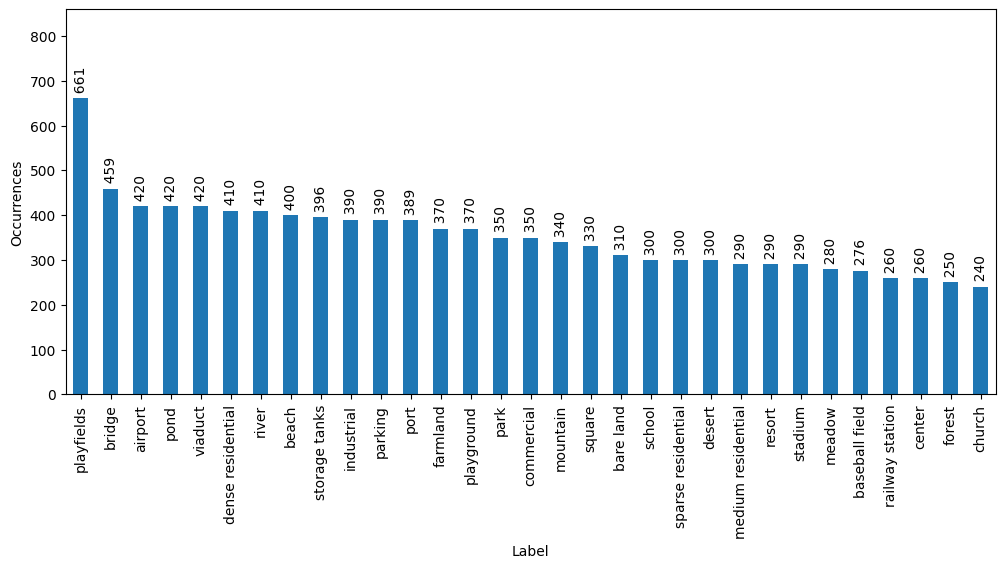

In [9]:
fig = plt.figure(figsize=(12, 5))
df["label"].value_counts().plot(kind='bar')
for index, value in enumerate(df["label"].value_counts().values):
    plt.text(index, value, "  "+str(value), rotation = 90, horizontalalignment="center")
plt.ylim([0, df["label"].value_counts()[0]+df["label"].value_counts()[0]*0.3])
plt.xlabel("Label")
plt.ylabel("Occurrences")